In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from IPython.display import display
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from scipy import stats
from textblob import TextBlob

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load spaCy's English language model for lemmatization
# python -m spacy download en_core_web_sm
spacy_nlp = spacy.load("en_core_web_sm")

# Consumer Complaints

Forschungsfrage: Wie kann ein automatisches Textklassifikationsmodell entwickelt werden, das Kundenbeschwerden basierend auf ihrem Inhalt den richtigen Produktkategorien zuordnet?

## Pre-Processing

Einlesen der Daten und Entfernen der Indexspalte.

In [3]:
# Load data
data = pd.read_csv('complaints_processed.csv')
# Delete first row (index)
data = data.drop(data.columns[0], axis=1)

data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


Überprüfung auf fehlende Werte. Da nur 10 von 160k der Narratives fehlen, werden sie einfach entfernt.

In [4]:
# Check the number of rows
print("Number of rows: ", data.shape[0])
# Check for missing values
print("Number of missing values: ", data.isnull().sum().sum())
data = data.dropna() #drop missing values
# Check number of rows after dropping missing values
print("Number of rows after dropping missing values ", data.shape[0])

Number of rows:  162421
Number of missing values:  10
Number of rows after dropping missing values  162411


Überprüfen, ob HTML-Tags, Satzzeichen und Zahlen vorhanden sind und ob Inhalte in Upper Case geschrieben sind. Da dies nicht zutrifft, werden keine Transformationen in diesem Sinne vorgenommen.

In [5]:
print("Number of rows with html tags:", data['narrative'].str.contains('<.*?>', regex=True).sum())
print("Number of rows with punctuation:", data['narrative'].str.contains('[^\w\s]', regex=True).sum())
print("Number of rows with numbers:", data['narrative'].str.contains('\d', regex=True).sum())
print("Number of rows with uppercase:", data['narrative'].str.contains('[A-Z]', regex=True).sum())

Number of rows with html tags: 0
Number of rows with punctuation: 0
Number of rows with numbers: 0
Number of rows with uppercase: 0


In [6]:
# Clculate length of narrative (before preprocessing)
data['narrative_len'] = data['narrative'].apply(lambda text: len(text.split()))

Erstellen einer neuen Spalte, in der Stoppwörter aus narrative entfernt werden. Entfernen der Zeilen mit weniger als 4 Wörtern in der neuen Spalte, da sie kaum aussagekräftig sind und nur einen Bruchteil der Gesamtdaten ausmachen

In [7]:
# Create a columns for the cleaned narrative
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

data['narrative_prep'] = data['narrative'].apply(lambda text: remove_stopwords(text))

In [8]:
# Show number of that are empty after removing stop words
print("Number of rows with empty narratives after removing stop words:", data[data['narrative_prep'] == ''].shape[0])
# Show number of rows with narratives that have less than 4 words
print("Number of rows with narratives that have less than 4 words:", data[data['narrative_prep'].str.split().apply(len) < 4].shape[0])

# Remove rows with narratives that have less than 4 words
data = data[data['narrative_prep'].str.split().apply(len) >= 4]

# Show number of rows after removing rows
print("Number of rows after removing rows", data.shape[0])

Number of rows with empty narratives after removing stop words: 7
Number of rows with narratives that have less than 4 words: 1756
Number of rows after removing rows 160655


In [9]:
#### KEINE GEDULD GEHABT LAUFEN ZU LASSEN ####
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
#lemma_text_list = []
#for doc in spacy_nlp.pipe(data["narrative_prep"]):
#    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
#data["text_lemma"] = lemma_text_list

In [10]:
# Calculate the length of lemmatized narrative
data['narrative_prep_len'] = data['narrative_prep'].apply(lambda text: len(text.split()))

In [11]:
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len
0,credit_card,purchase order day shipping amount receive pro...,230,purchase order day shipping receive product we...,203
1,credit_card,forwarded message date tue subject please inve...,132,forwarded message date tue subject investigate...,121
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,forwarded message cc sent friday pdt subject f...,147
3,credit_reporting,payment history missing credit report speciali...,131,payment history missing credit report speciali...,110
4,credit_reporting,payment history missing credit report made mis...,123,payment history missing credit report mistake ...,102


## Explorative Data Analysis

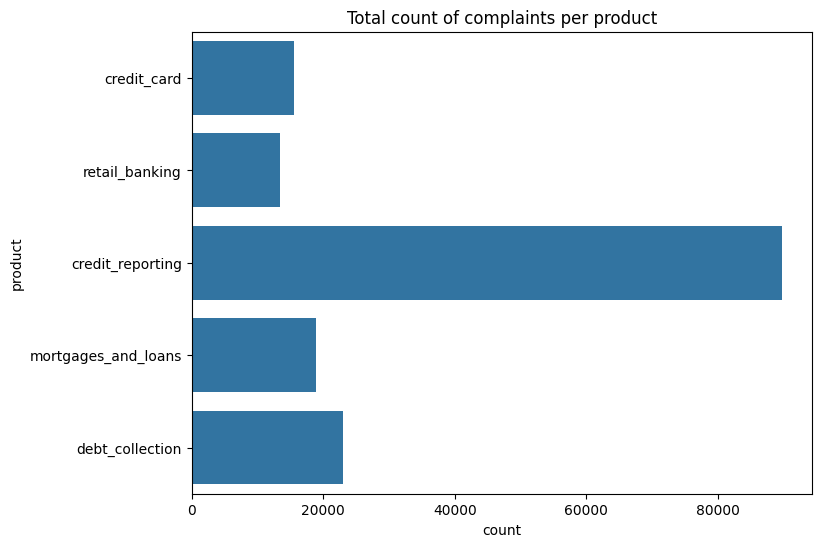

In [12]:
# Total count of complaints per product
plt.figure(figsize=(8, 6))
sns.countplot(data['product'])
plt.title('Total count of complaints per product')
plt.show()

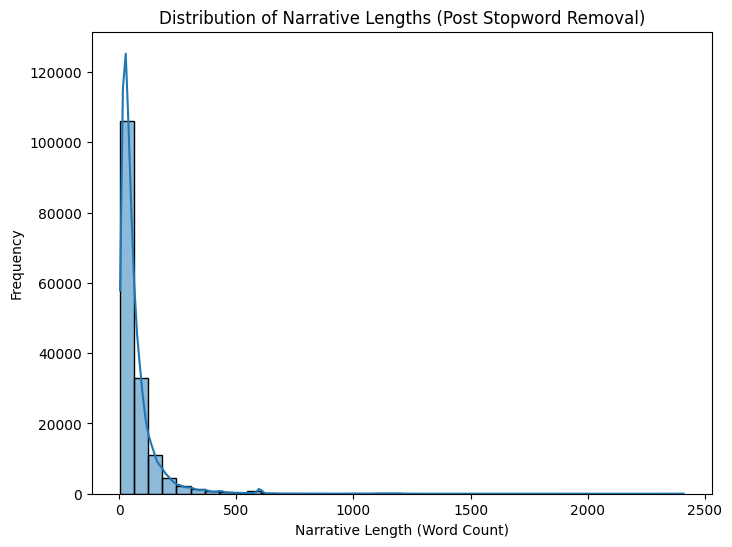

In [13]:
# Distribution of Narrative Lengths (after stopword removal)
plt.figure(figsize=(8, 6))
sns.histplot(data['narrative_prep_len'], bins=40, kde=True)
plt.title('Distribution of Narrative Lengths (Post Stopword Removal)')
plt.xlabel('Narrative Length (Word Count)')
plt.ylabel('Frequency')
plt.show()

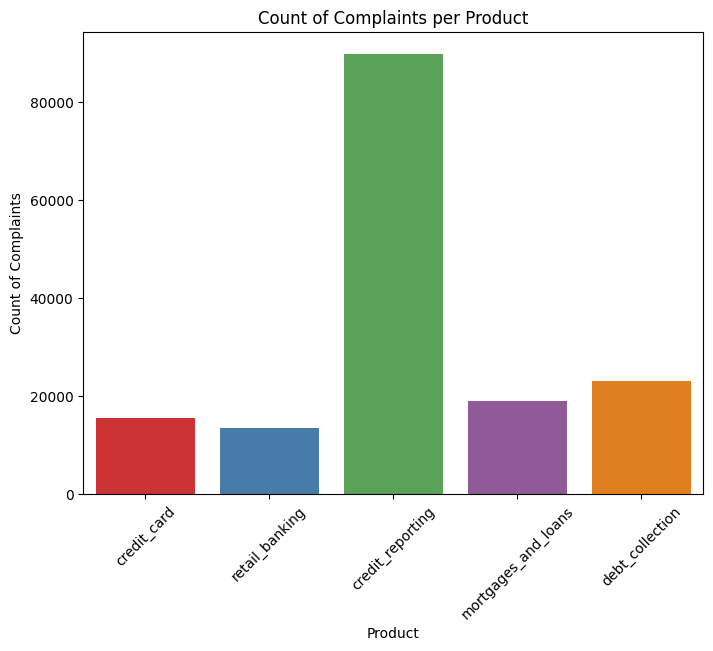

In [14]:
# Count of Complaints per Product
plt.figure(figsize=(8, 6))
sns.countplot(x='product', data=data, palette='Set1')
plt.title('Count of Complaints per Product')
plt.xlabel('Product')
plt.ylabel('Count of Complaints')
plt.xticks(rotation=45)
plt.show()

In [15]:
# 1. Overall Summary Statistics for length_narrative_preprocessed
overall_summary = data['narrative_prep_len'].describe()

# Display overall summary statistics
print("Overall Summary Statistics - length_narrative_preprocessed:")
display(overall_summary)

Overall Summary Statistics - length_narrative_preprocessed:


count    160655.000000
mean         71.113342
std          97.334293
min           4.000000
25%          24.000000
50%          44.000000
75%          83.000000
max        2410.000000
Name: narrative_prep_len, dtype: float64

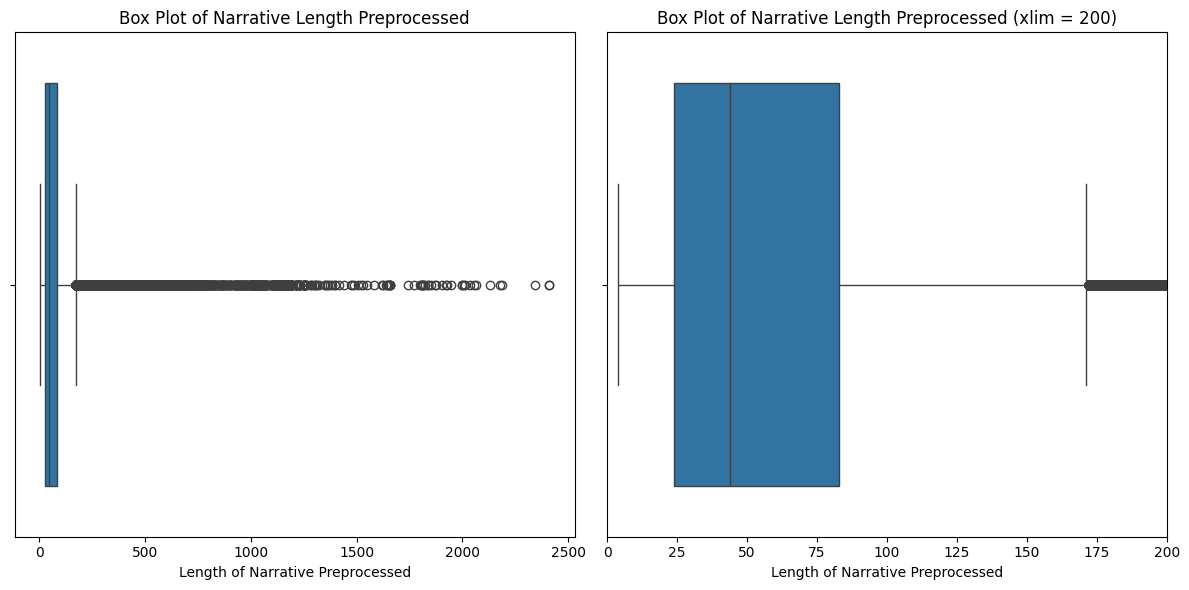

In [16]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot of overall narrative length on the first subplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[0])  # Create the boxplot
axes[0].set_title('Box Plot of Narrative Length Preprocessed')
axes[0].set_xlabel('Length of Narrative Preprocessed')

# Boxplot of overall narrative length (with xlim=200) on the second subplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[1])  # Create the boxplot
axes[1].set_xlim(0, 200)  # Set the x-axis limit
axes[1].set_title('Box Plot of Narrative Length Preprocessed (xlim = 200)')
axes[1].set_xlabel('Length of Narrative Preprocessed')

plt.tight_layout()
plt.show()

In [17]:
# 2. Group-wise Summary Statistics for each product
grouped_summary = data.groupby('product')['narrative_prep_len'].describe()

# Display group-wise summary statistics
print("\nGroup-wise Summary Statistics by Product:")
display(grouped_summary)


Group-wise Summary Statistics by Product:


,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
credit_card,15530.0,84.479395,85.383704,4.0,34.0,61.0,106.0,2038.0
credit_reporting,89748.0,61.205943,94.411572,4.0,21.0,36.0,65.0,2410.0
debt_collection,22987.0,69.811241,99.643645,4.0,23.0,44.0,83.0,2064.0
mortgages_and_loans,18955.0,101.391295,112.176236,4.0,41.0,72.0,121.0,2341.0
retail_banking,13435.0,81.355787,91.190146,4.0,28.0,57.0,101.0,1581.0


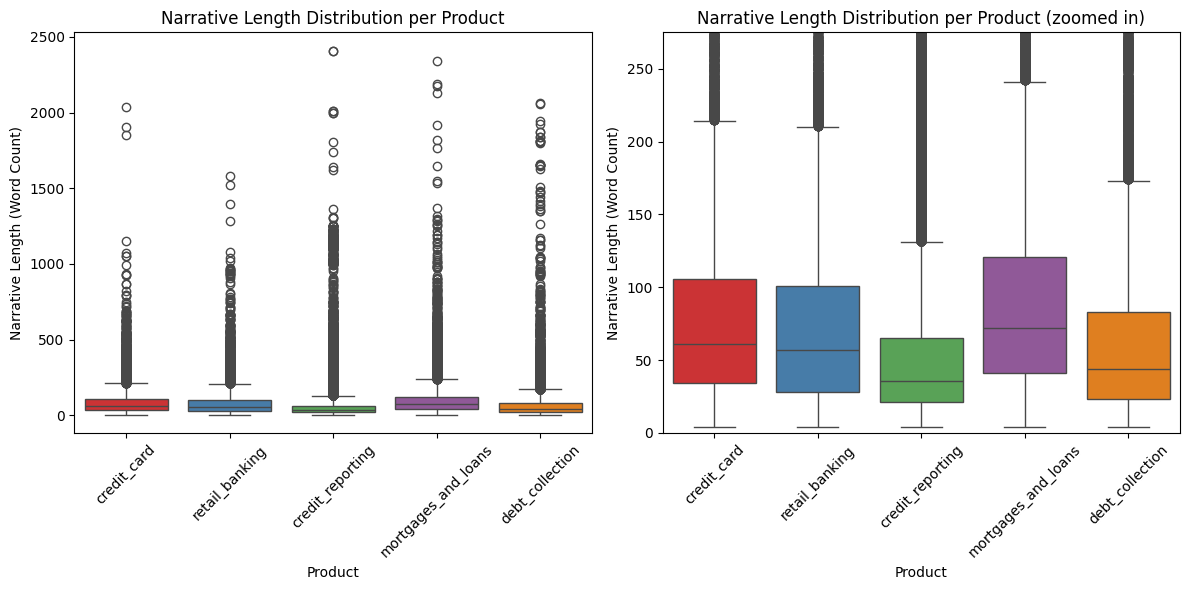

In [18]:
# Boxplot of Narrative Length per Product
def boxplot_narrative_length(data, title, ylim: int = None, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x='product', y='narrative_prep_len', data=data, palette='Set1', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Product')
    ax.set_ylabel('Narrative Length (Word Count)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ylim is not None:
        ax.set_ylim(0, ylim)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first boxplot
boxplot_narrative_length(data, title='Narrative Length Distribution per Product', ax=axes[0])

# Plot the second boxplot with a y-limit of 275
boxplot_narrative_length(data, title='Narrative Length Distribution per Product (zoomed in)', ylim=275, ax=axes[1])

plt.tight_layout()
plt.show()

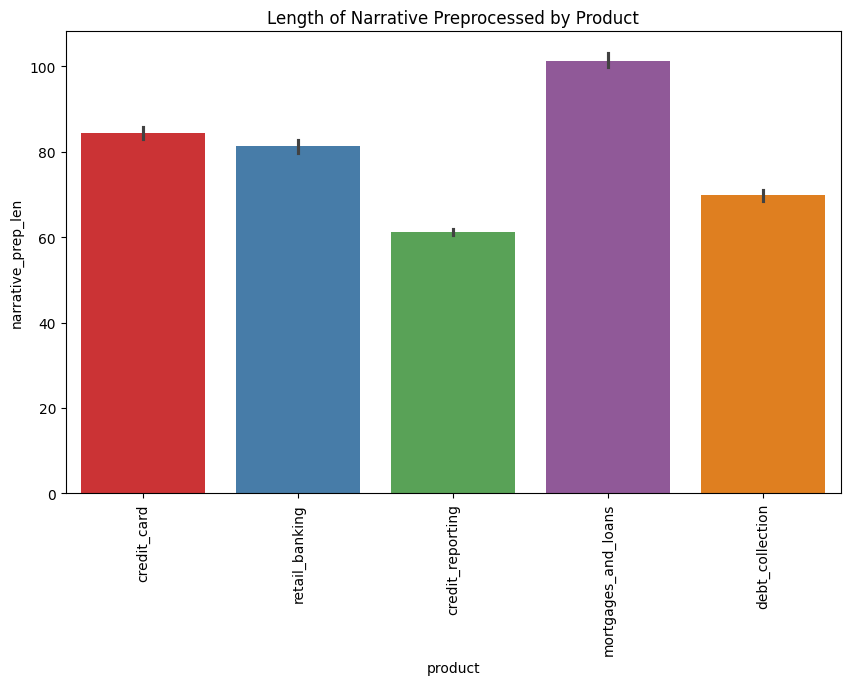

In [19]:
# Barplot of Narrative length per Product
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='product', y='narrative_prep_len', palette ='Set1')
plt.xticks(rotation=90)
plt.title('Length of Narrative Preprocessed by Product')
plt.show()

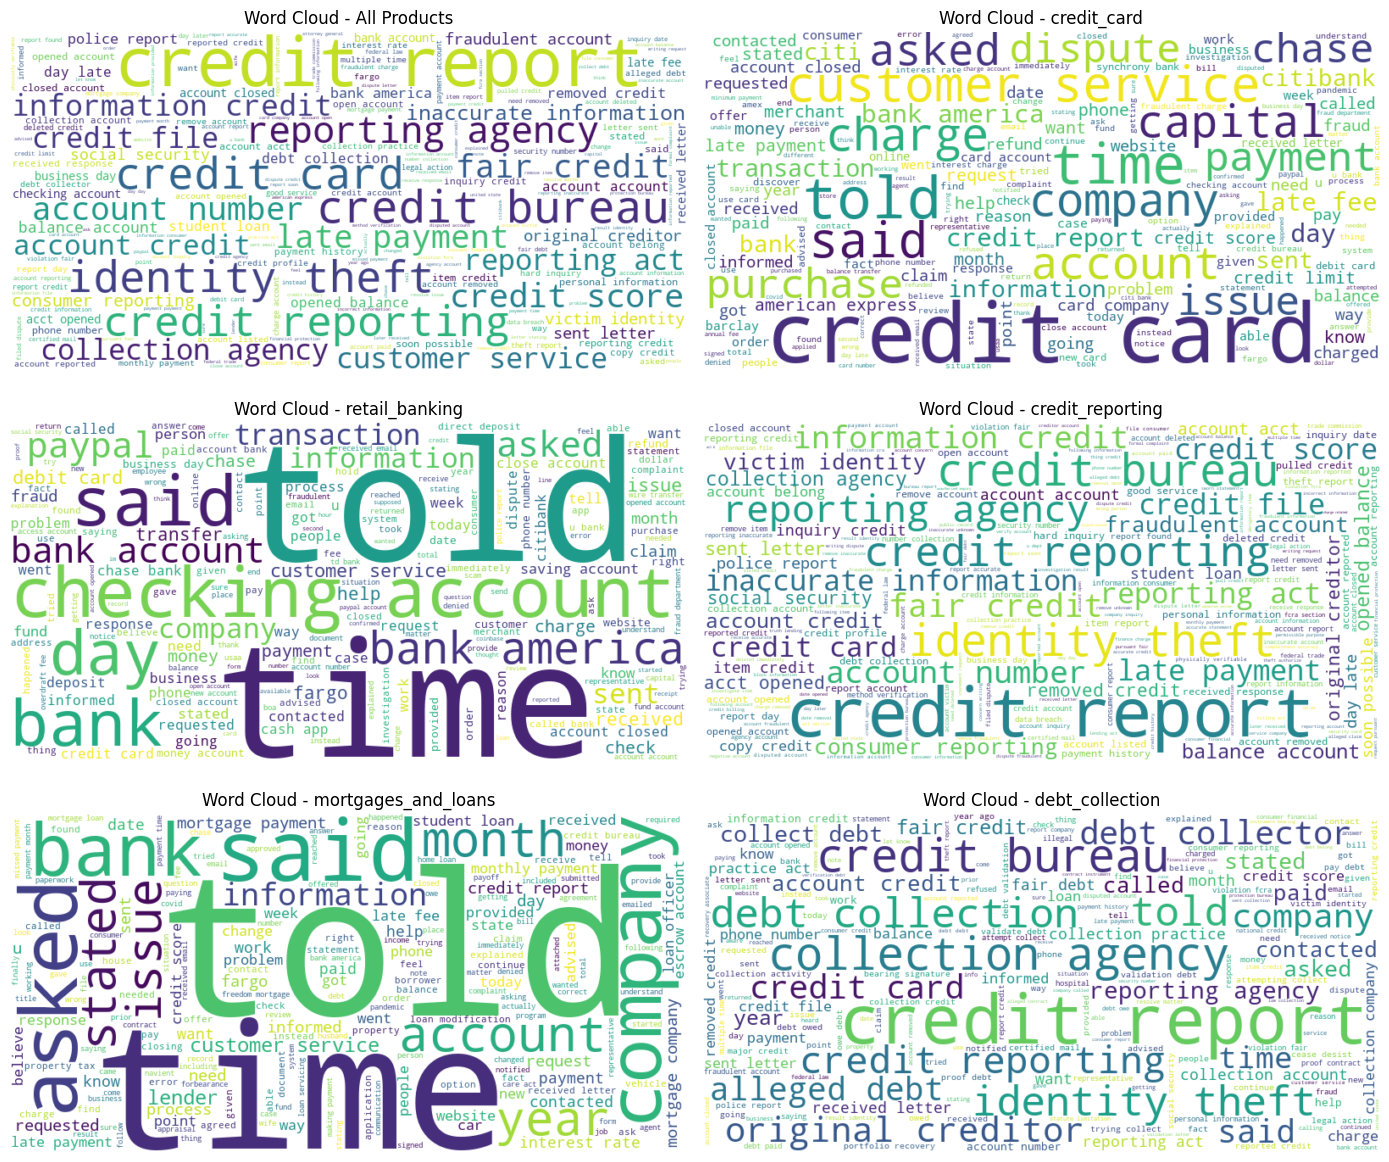

In [20]:
# Word clouds for the entire dataset and five for each product category
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Generate word cloud for the whole dataset
all_words = ' '.join(data['narrative_prep'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
axes[0, 0].imshow(wordcloud, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Word Cloud - All Products')

# Generate word clouds for each product category
product_categories = data['product'].unique()

for i, product in enumerate(product_categories):
    product_words = ' '.join(data[data['product'] == product]['narrative_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_words)
    row, col = divmod(i + 1, 2)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Word Cloud - {product}')

# Remove any unused subplots
for j in range(len(product_categories) + 1, 6):
    row, col = divmod(j, 3)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

 #### TF-IDF
Extraktion wichtiger Textmerkmale mit TF-IDF

In [21]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data['narrative_prep'])

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
display(tfidf_df.head())

,account,bank,card,collection,company,consumer,credit,day,debt,dispute,information,letter,loan,payment,received,report,reporting,sent,time,told
0,0.000000,0.000000,0.280322,0.0,0.232382,0.000000,0.000000,0.473728,0.000000,0.541298,0.0,0.000000,0.000000,0.000000,0.23051,0.000000,0.000000,0.498774,0.219286,0.000000
1,0.188362,0.577591,0.453650,0.0,0.470085,0.000000,0.398988,0.000000,0.114002,0.000000,0.0,0.000000,0.000000,0.098216,0.00000,0.000000,0.000000,0.100897,0.000000,0.110072
2,0.384088,0.000000,0.693779,0.0,0.000000,0.400155,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.300410,0.00000,0.000000,0.152749,0.154304,0.271359,0.000000
3,0.189081,0.347878,0.000000,0.0,0.000000,0.000000,0.171648,0.000000,0.000000,0.000000,0.0,0.204487,0.579487,0.591550,0.00000,0.279791,0.000000,0.000000,0.089057,0.000000
4,0.213398,0.392617,0.000000,0.0,0.000000,0.000000,0.193723,0.000000,0.000000,0.000000,0.0,0.230785,0.392407,0.667626,0.00000,0.315773,0.000000,0.000000,0.100511,0.000000


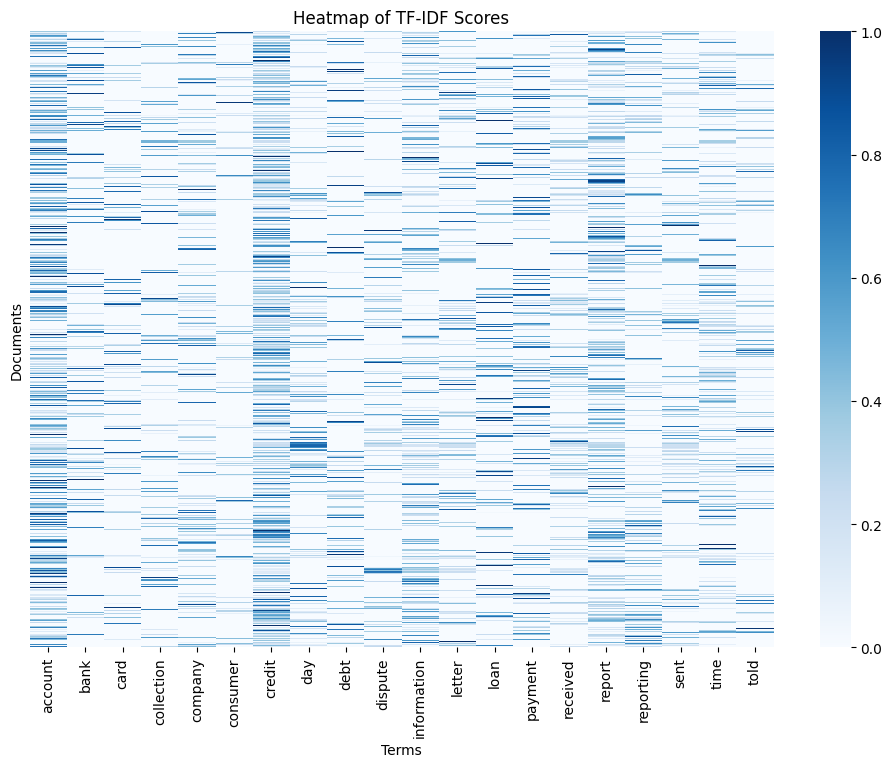

In [22]:
# Plot a heatmap of the TF-IDF matrix
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df, cmap='Blues', yticklabels=False)
plt.title('Heatmap of TF-IDF Scores')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

Die Heatmap zeigt, wie dieTF-IDF Scores über verschiedene Narratives (Documents) verteilt sind.

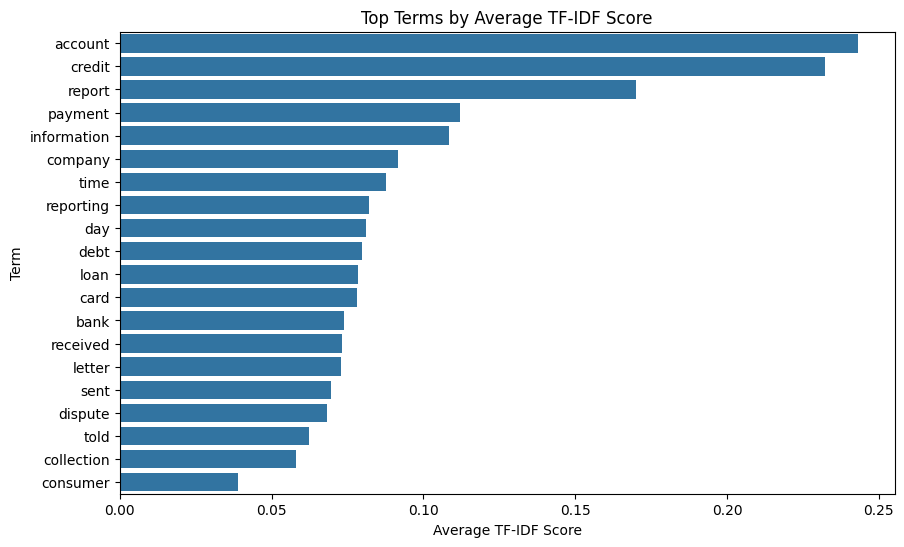

In [23]:
# Get the average TF-IDF score for each term across all documents
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Plot the top terms by average TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index)
plt.title('Top Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

#### Top Wörter nach TF-IDF Score nach Produkten:

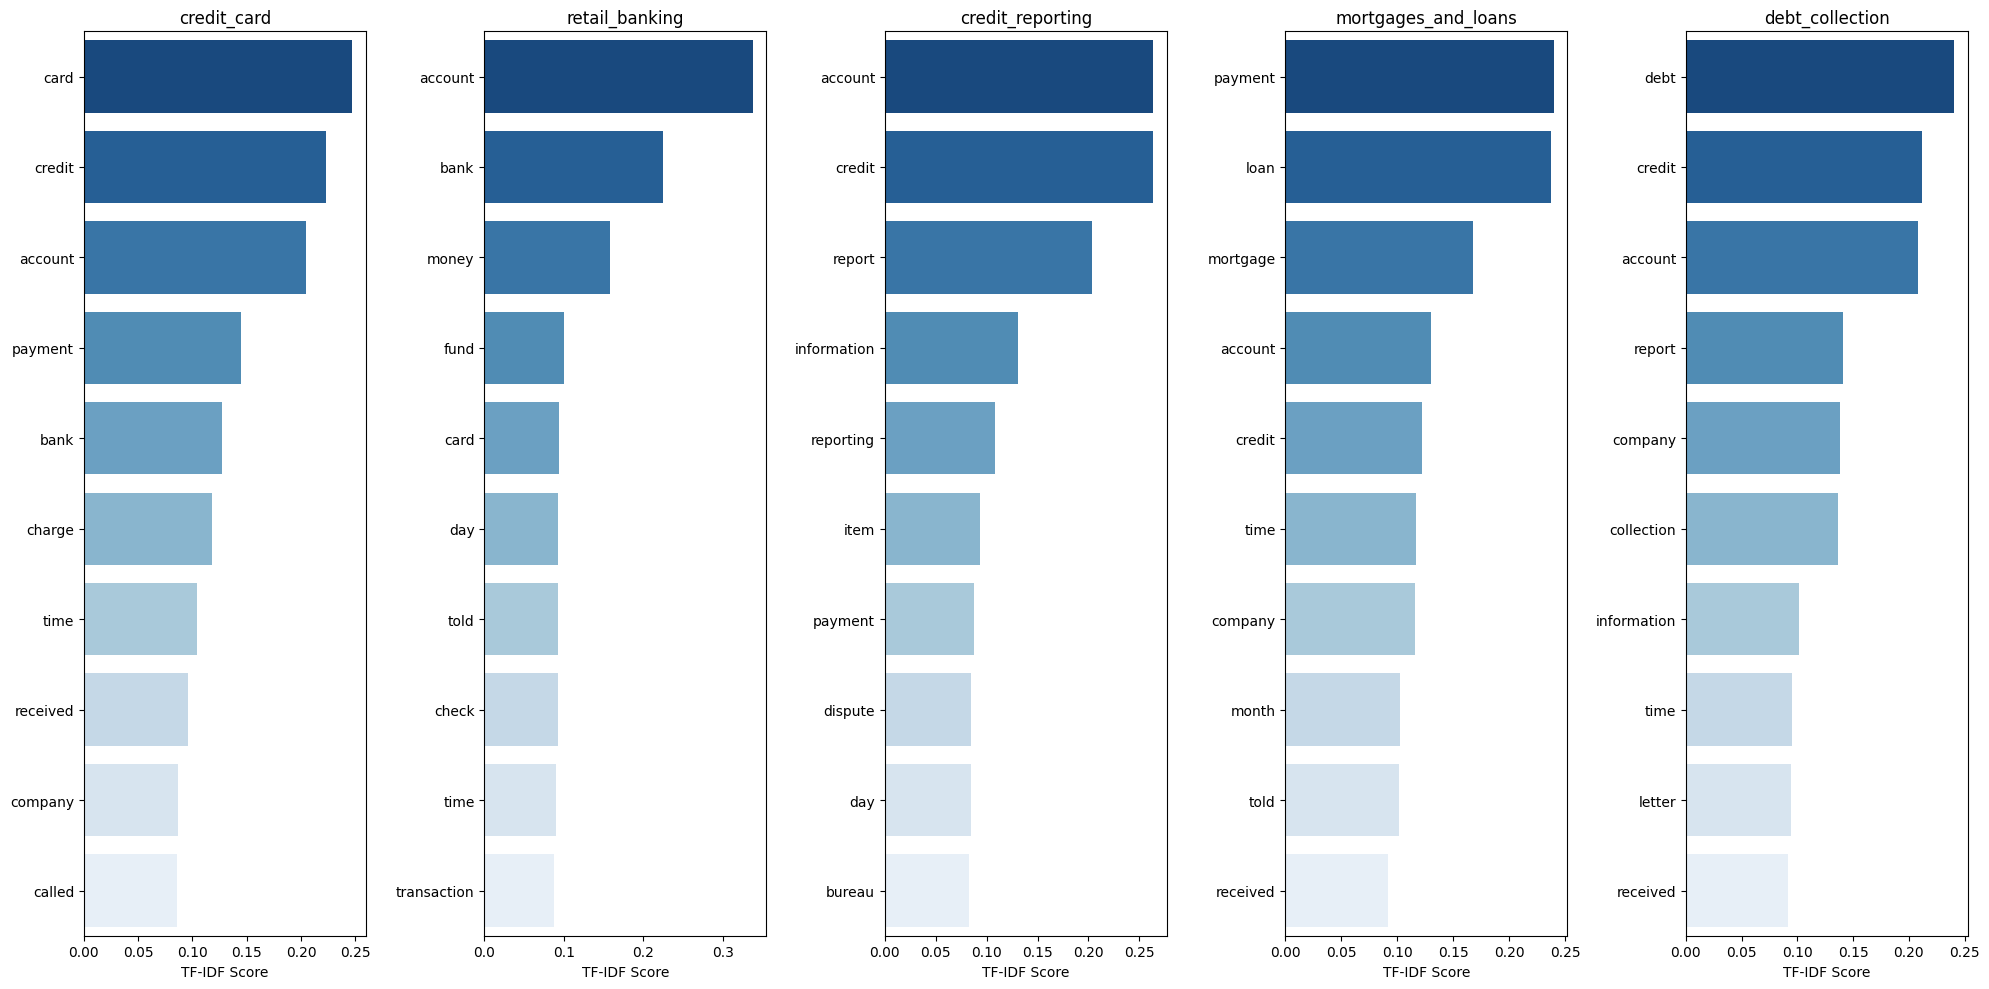

In [24]:
products = data['product'].unique()

# Initialize a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=20)

# Create a figure with a 2x5 grid of subplots (adjust the number of rows and columns based on your product count)
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten to easily index subplots

# Iterate through each product and its corresponding subplot
for i, product in enumerate(products):
    # Filter the data for the current product
    product_data = data[data['product'] == product]
    
    # Apply TF-IDF on the 'narrative_prep' column for the current product
    tfidf_matrix = tfidf.fit_transform(product_data['narrative_prep'])
    
    # Create a DataFrame with the TF-IDF scores for each term
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    
    # Compute the average TF-IDF score for each term
    tfidf_mean = tfidf_df.mean().sort_values(ascending=False)
    
    # Take the top 10 terms with the highest TF-IDF scores
    top_words = tfidf_mean.head(10)
    
    # Plot the top words for this product in its corresponding subplot
    sns.barplot(x=top_words.values, y=top_words.index, ax=axes[i], palette = 'Blues_r')
    axes[i].set_title(f'{product}')
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_ylabel('')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#### Sentiment-Analyse: 
Durchführung einer Sentiment-Analyse um herauszufinden, ob der Text negativ, neutral oder positiv ist.

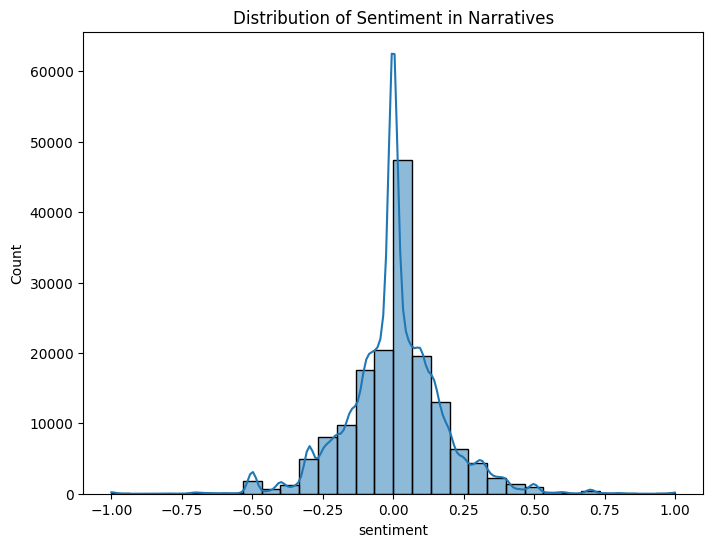

In [25]:
data['sentiment'] = data['narrative_prep'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8,6))
sns.histplot(data['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment in Narratives')
plt.show()

Der berechnete Sentiment-Score reicht von -1 (negativ), über 0 (neutral) bis zu 1 (positiv).

#### Sentiment-Analyse nach Produkt:

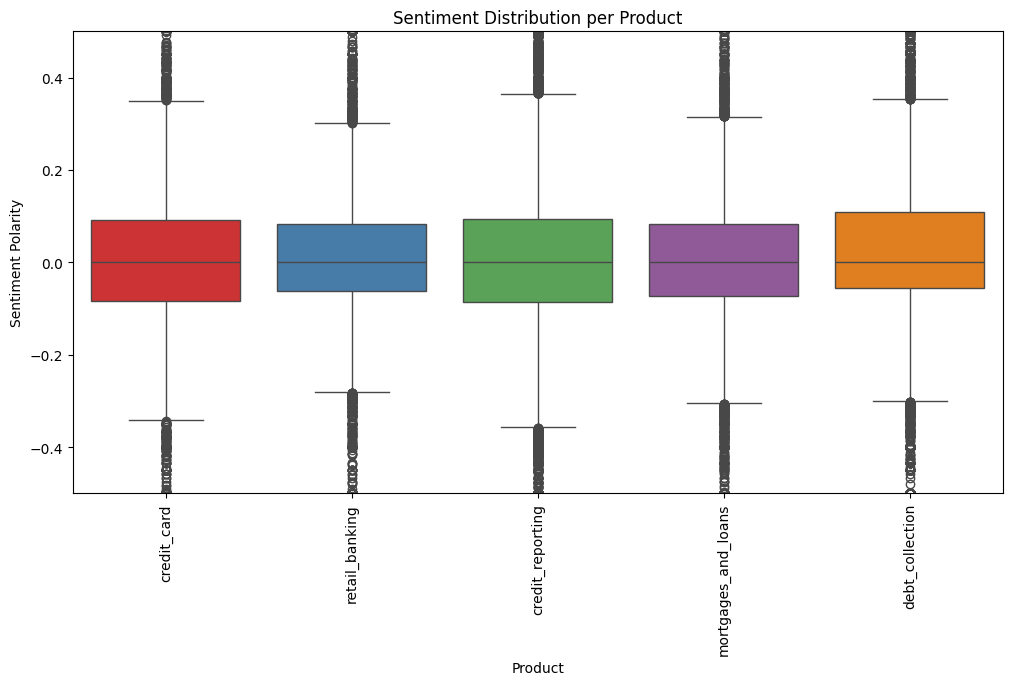

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='product', y='sentiment', palette='Set1')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.title('Sentiment Distribution per Product')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Product')
plt.show()